<font color='brown'>

# Predicting annual remuneration for STEM professionals

</font>

<font color='brown'>

# Contents:

A. Analysis objective \
B. Summary and conclusions \
C. Implementation of the proposed project \
D. References \
E. Requirements file
    
</font>    

<font color='brown'>
    
# A. Analysis objective
    
</font>   

### Background

Recruitment in STEM (Science, Technology, Engineering, and Mathematics) occupations is expected to boom over the next 10 years and grow at least twice as fast as that of any other sector in the US alone (U.S. Bureau of Labor Statistics, 2022). It occupations are evolving quickly, particularly in the areas of AI and ML engineering. Having an-up-to date guide on expected remuneration levels for STEM occupations based on employee attributes (experience, qualifications, socio-demographics, companies, etc.) can help manage the expectations for both recruiters and job seekers.  

There are few information sources or services available that can be used to build such a tool for any sector. However a relatively new company, levels.fy, has started collecting low-level quantitative data on STEM employees which could be used in a proof of concept (POC) project - to build an algorithm to predict a remuneration level for STEM occupations based on employee attributes. levels.fy hold hundrends of data points on hundreds of thousands of STEM professionals, including their levels of remuneration.

### Proposal

This project considers building a statistical model that predicts the level of  remuneration of a STEM occupation based on an employees attributes using the levels.fy data. Most of the features in the data have extremely high cardinality (000s) so sparsity becomes an issue for processing feature vectors. Big data techniques and tools, like feature hashing and clustering, will be used.

The levels.fy data is sourced from Kaggle (https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries).

### Objectives

- Build a model that predicts a person's annual remuneration in the STEM sector
- Develop a Spark pipeline that can be run repeatably on new data to provide prediction of remuneration for an unseen person (in terms of data)

### The data

A sample of the levels.fy is data used for the POC. It comprises 29 socio-demographic and professional features for around 65K people. It also includes their 'total year compensation' which is considered the sum of their 'base salary', 'stock grant' and 'bonus'. The data includes good representation of people from across the main tech cities around the world.

A quick summary of the ~65K of records shows us cardinality of the categorical features is high so dimension reduction will be required and also there is significant spread in the numeric features so some scaling and clipping may be required:

![sum_stats](images\sum_stats.png)

### Approach

The follow strategy will be undertaken:
- Create a Spark session on an available Cluster
- Upload the data onto HDFS
- Convert the data into a dataframe ahead of analysis
- Undertake a data audit to gain an understanding of all of the features
- Undertake some exploratory data analysis (EDA) to gain insights on the main features
- Clean and transform the data as required from the data audit/EDA steps ahead of model building, including new feature creation
- Using Spark ML (for dataframes) create transformers and estimators to build predictive models
- Create pipelines to find the best predictive model using different algorithms, different number of input features and hyperparameter tuning
- Contemplate what extra steps could make the final model better

The required coding will be undertaken with PySpark and PySpark SQL where appropiate. Python may also be used where required such as for plotting.

### Hypothesis tests

A key piece of work in the EDA will be investigating the relationships between the categorical and continuous independent features respectively and the continuous dependent feature (total yearly compensation) with the intention of identifying which features can be considered as redundant (e.g. collinear) or irrelevent (have no relationship with the target) ahead of the modelling. This helps reduce the risk of building an over-complicated and over-fitted model.

Visual checks via plotting each feature versus the target will give a quick view of relationships but hypothesis testing will be required to identify those relationships which are statistically significant and are not just aberations. Unfortunately the version of Spark on the cluster does not have the UnivariateFeatureSelector tool to help identify top features via testing so instead the following will be undertaken:

##### Continuous features:

- Calculate the Pearson correlation score for each pair of features (including the target feature) using the PySpark correlation package to identify which features ahave the strongest/weakest relationships with the target and the pairwise correlations to identify collinearity
    
- Confirm the findings above by calculating the required p-values to test the following hypotheses for any pair of features:

     H0 - there is no correlation between the two features \
     H1 - there is correlation between the two features
      
##### Categorical features:
  
- Identify features which are considered irrelevent due to its levels not differentiating total yearly compensation
- This will be done by undertaking the one-way ANOVA statistical test for the hypotheses of:

  H0: mean(i)=mean(j) for any i,j which are levels of the categorical feature \
  H1: mean(i)<>mean(j) for any i,j which are levels of the categorical feature


- The code to do this will be developed in PySpark

### Model algorithms

Three different types of modelling algorithms will be used - linear regression, random forest and gradient boosted tree regression. The first requires assumption of linearity and homogeneity of variances while the others do not. The EDA step will explore the best way to convert the categorical features into numeric features as required for Spark ML. The models will be optimized to ensure only the best features are included and the best parameters are used.

The models will be run using Spark ML pipelines which enable easily repeatable runs to be undertaken and to easily run on new data. Spark server history enables us to see the performance of jobs when run in terms of stages and tasks being executed and their run times.

### Desired outcomes

To have confidence in the deliverable in that the the model should produce an R2 of at least 70% (Percentage of variance explained) and the lowest possible RMSE and overall mean residual. Plus the residuals should look random (from the tree-based models) and normally distributed for the linear model. If this is not achieved then thoughts on possible variations in approach will be provided.

### Note

The data used is stored in HDFS as per the path of section (C)(4) below.

<font color='brown'>
    
# B. Summary and conclusions
    
</font>   

#### Overall

The finalised model was disappointing with an R2 of only 64.5% and an RMSE of 73,433 (versus a standard deviation of 138,037 for the target feature 'total yearly compensation'). Hence delivering a model which only explains only 64% of the variance is not within the original expectation of at least 70%.

#### Top drivers of high compensation

After cleaning and any necessary transformations, the One Hot Encoding resulted in 80 features being used initially. Understanding the feature importance scores (from the GBT regressor model) of these does give good insight into what might be driving higher 'total yearly compensation' and they highlighted some unexpected results. The top 15 features ranked by these scores were:

![chart1](images\chart1.png)

The top 15 shows 'years of experience' and 'years at company' are significant drivers of total yearly compensation which seems logical. However the high ranking of 'location' outside of California driving higher compensation than for those people who live in tech areas of California seems counter-intuitive. If someone's 'title' involves 'software engineering' or their 'company' is Google, or they have the tag of 'AI/ML' or those hold a PhD, they are more likely to have higher total yearly compensation. The features of 'Race' and 'gender' are quite low in the feature importance rankings.
    
#### Best model

The model performances did improve across the different algorithms:

![table1](images\table1.png)

Having 80 features in a model makes it complicated and prone to overfitting. Continuing with the GBT regressor algorithm two strategies were undertaken to try to improve the model:

1. Remove features with low feature importance

   This was determined by running the model over various numbers of features (10, 20, 30,..., 80) using the above feature
   importance rankings. It was found that there was no gain in performance after the top 40 features so the number of features
   was reduced by a half
   
   
2. Tune the hyperparameters using grid search and Spark ML CrossValidator

   The choice of parameters in the grid search space was limited due to memory issues on Spark. It was very surprising that it
   could not cope with 60K rows and 11 features for maxIter=200 in GBT regressor model. No improvement in performance was
   achieved by altering depth of the trees or number of trees in the ensemble approach with only two options each in the grid
   space. The log from Spark server history shows that the data process grew significantly and which I am unsure as to why (?):

   ![spark_hist](images\spark_hist.png)

The final model with only 40 features and optimised hyperparameters increased R2 by 0.5 percentage points, RMSE of 73,954 and an average residual of 618 which is relatively small compared to a mean total yearly compensation value of USD $226K

#### Possible ways forward

To try and improve the model the following steps could be taken:
- Engineer some more pertinent features e.g. current job tenure as a proportion of STEM career = years in current job/total years of experience
- Understand if more data features are available at source such as qualification major, management experience or number of jobs held in STEM
- Consider creating separate models for STEM professionals in California, rest of USA and rest of world as attributes maybe country centric
- Try using a later version of Spark that has the latest feature selectors
- Getting access to more memory for better grid searches or switch to using Spark ML TrainValidationSplit

<font color='brown'>
    
# C. Implementation of the proposed project
    
</font>   

<font color='darkblue'>

This part undertakes all the analysis and model building using PySpark on the cluster

</font>

## Contents

1. Set up Spark on Jupyter notebook
2. Set up required libraries
3. Get data onto HDFS
4. Convert data into a dataframe
5. Audit the data
6. Data cleaning
7. Exploratory data analysis
8. Predicting a STEM professional's 'total yearly compensation'

## 1. Set up Spark on Jupyter notebook

<font color='darkblue'>

This section sets up a Spark session on the cluster

</font>

In [ ]:
import pyspark
from pyspark.context import SparkContext

# Run on Spark by starting with "sc"
# appName 'cw2' identifies the job for user 'jmccl001' on the cluster
sc = pyspark.SparkContext(appName='cw2')

# Set up dataframe capability
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('cw2').getOrCreate()

22/09/11 23:48:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "ERROR".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<font color='darkblue'>

Check the configuration to ensure using the cluster ('spark.master', 'yarn')

</font>

In [ ]:
sc._conf.getAll()[6:11]

[('spark.driver.host', 'lena-master'),
 ('spark.driver.appUIAddress', 'http://lena-master:4044'),
 ('spark.master', 'yarn'),
 ('spark.driver.port', '33543'),
 ('spark.history.fs.logDirectory', 'hdfs:///user/spark/history')]

## 2. Set up required libraries

<font color='darkblue'>

This section defines all the PySpark and Python libraries required for the subsequent analysis and model building \
For dataframes we have to use ML instead of MLlib for RDDs
    
</font>

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Window, DataFrameWriter
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import *
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.stat import Correlation
import pyspark.ml.evaluation as ev
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, f_oneway
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## 3. Get data onto HDFS

<font color='darkblue'>

This section demonstrates how the source data was placed onto HDFS using the following steps \
Note that the source data was firstly loaded up into master node in the cluster manually via Jupyter notebooks in the Hadoop Cluster Applications

</font>

In [ ]:
# Create a directory on HDFS
#!/opt/hadoop/current/bin/hadoop fs -mkdir cw2

# Copy data from masternode into cw2 directory in HDFS
#!/opt/hadoop/current/bin/hadoop fs -copyFromLocal Levels_Fyi_Salary_Data.csv ./cw2

# Change read write privileges from -rw-r--r-- to -rwxr-xr-x
#!/opt/hadoop/current/bin/hadoop fs -chmod +x ./cw2/Levels_Fyi_Salary_Data.csv

# Check file loaded into HDFS and its privileges
!/opt/hadoop/current/bin/hadoop fs -ls cw2/

Found 1 items
-rwxr-xr-x   3 jmccl001 users   12781635 2022-09-06 11:17 cw2/Levels_Fyi_Salary_Data.csv


## 4. Convert data into a dataframe

<font color='darkblue'>

This section details how the initial dataframe is created and undertakes some basic cleaning
    
Notes:
- Dataframe format was preferred over RDD format due to its inherent advantages
- The resulting dataframe is automatically a distributed collection of datapoints when processed in Spark and interacting with HDFS
- As dataframes are immutable data structures, for each key change/manipulation made, a new dataframe results

</font>

Input data into a dataframe and infer the data types and use first row as a header row

In [ ]:
df=spark.read.csv('hdfs:///user/jmccl001/cw2/Levels_Fyi_Salary_Data.csv', header=True, inferSchema=True)

Check key facts about dataframe

In [ ]:
# Check number of partitions
print(df.rdd.getNumPartitions())

# Check size
print((df.count(), len(df.columns)))

# Check schema
#print(df.printSchema())

# Eye ball values of example record
print(df.head(1))

2
(62646, 29)
[Row(timestamp='6/7/2017 11:33:27', company='Oracle', level='L3', title='Product Manager', totalyearlycompensation=127000, location='Redwood City, CA', yearsofexperience=1.5, yearsatcompany=1.5, tag='NA', basesalary=107000.0, stockgrantvalue=20000.0, bonus=10000.0, gender='NA', otherdetails='NA', cityid='7392', dmaid='807', rowNumber='1', Masters_Degree='0', Bachelors_Degree='0', Doctorate_Degree='0', Highschool='0', Some_College='0', Race_Asian=0, Race_White=0, Race_Two_Or_More=0, Race_Black=0, Race_Hispanic=0, Race='NA', Education='NA')]


<font color='darkblue'>

Remove the One Hot Encoded versions of the Education and Race features as we will recreate OHE features systematically when using PySpark pipelines

</font>

In [ ]:
df1=df.drop('Highschool','Some_College','Bachelors_Degree','Masters_Degree','Doctorate_Degree','Race_White','Race_Black', \
            'Race_Hispanic','Race_Asian','Race_Two_Or_More')

<font color='darkblue'>

The following features need to have their formats converted:

- timestamp to date format
- cityid, dmaid, rowNumber to numeric format

</font>

In [ ]:
# timestamp

# Remove time
df2=df1.withColumn('month', split(df1['timestamp'], '/').getItem(0))\
       .withColumn('day', split(df1['timestamp'], '/').getItem(1))\
       .withColumn('year', split(df1['timestamp'], '/').getItem(2))
df3=df2.withColumn('year1', split(df2['year'], ' ').getItem(0)).drop('year')
# Pad day and month
df4=df3.withColumn('month',lpad(df3.month, 2, '0')).withColumn('day',lpad(df3.day, 2, '0'))
# Bring together into new date column & drop original one
df5=df4.withColumn('date',concat_ws("-",df4.month,df4.day,df4.year1)).drop("timestamp")
# Convert into date format MM-DD-YYYY
df6=df5.withColumn("date1",to_date(col("date"),"MM-dd-yyyy")).drop('month','day','year1','date')

# 'cityid', 'dmaid', 'rowNumber'

df7=df6.withColumn('cityid',df6['cityid'].cast('integer'))\
       .withColumn('dmaid',df6['dmaid'].cast('integer'))\
       .withColumn('rowNumber',df6['rowNumber'].cast('integer'))

In [ ]:
# Check size
print((df7.count(), len(df7.columns)))

(62646, 19)


## 5. Audit the data

<font color='darkblue'>
    
This section investigates various aspects of the data to see what cleaning and data preparation is required ahead of exploratory data analysis and modelling

</font>

### a. Check for nulls and missings

<font color='darkblue'>

Here we want to understand the size of the number of records containing missing or null values \
As some algorithms cannot handle missing or null values it is important they are treated appropriately e.g. imputation or deletion
    
</font>

Categorical features:

In [ ]:
cat_cols=['company','level','title','location','tag','gender','otherdetails','Race','Education']
df7.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in cat_cols]).show()

+-------+-----+-----+--------+---+------+------------+----+---------+
|company|level|title|location|tag|gender|otherdetails|Race|Education|
+-------+-----+-----+--------+---+------+------------+----+---------+
|      1|    1|    2|       2|  2|     2|           2|   6|        6|
+-------+-----+-----+--------+---+------+------------+----+---------+



Numeric features:

In [ ]:
cts_cols=['totalyearlycompensation','yearsofexperience','yearsatcompany','cityid','dmaid','rowNumber','basesalary',
          'stockgrantvalue','bonus']
df7.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in cts_cols]).show()

+-----------------------+-----------------+--------------+------+-----+---------+----------+---------------+-----+
|totalyearlycompensation|yearsofexperience|yearsatcompany|cityid|dmaid|rowNumber|basesalary|stockgrantvalue|bonus|
+-----------------------+-----------------+--------------+------+-----+---------+----------+---------------+-----+
|                      2|                2|             2|    20|   19|       14|         2|              2|    2|
+-----------------------+-----------------+--------------+------+-----+---------+----------+---------------+-----+



Date feature:

In [ ]:
date_cols=['date']
df7.select([count(when(col('date1').isNull(),'date1')).alias('date1')]).show()

+-----+
|date1|
+-----+
|    4|
+-----+



<font color='darkblue'>

Findings and actions:
    
As a very neglible number of rows contain missings or nulls the benefit of simply deleting them is greater than that of the effort required of imputation
    
</font>

In [ ]:
df8=df7.dropna()

In [ ]:
# Only 23 records removed
print((df8.count(), len(df8.columns)))

(62623, 19)


### b. Categorical features - check cardinality

<font color='darkblue'>

Here we need to know how many unique levels exist in each categorical feature so their treatment preparation can be decided

This is because most ML algorithms only use numeric data so categorical features need to be converted into numeric format
High numbers of levels in categorical features can result in high dimensional/very sparse vectors inputted into algorithms which can affect their performance and also make interpretation of their results impractical

</font>

In [ ]:
cats=['company','level','title','location','tag','gender','otherdetails','Race','Education']

In [ ]:
dic1={}
for i in cats:
    dic1[i]=df8.select(countDistinct(i)).collect()[0][0]

In [ ]:
dic1

{'company': 1633,
 'level': 2924,
 'title': 15,
 'location': 1050,
 'tag': 3060,
 'gender': 5,
 'otherdetails': 12826,
 'Race': 6,
 'Education': 6}

<font color='darkblue'>

Observation: Very high cardinality for some features which wil require treament to collapse into lower cardinality ahead of modelling

</font>

### c. Categorical features - check number levels of each feature

<font color='darkblue'>

Here we will:
- View each unique level of each categorical feature
- See the distribution of records by each level
- Understand what are the most/least populated levels in each feature
    
This information will be used for collapsing the levels to reduce high cardinality

</font>

Define a function which used PySpark to calculate the frequency distribution of a feature \
Note that I am not creating a PySpark UDF with Python code due to their inability to run optimally on the cluster (SparkByExamples.com, 2022)


In [ ]:
def level_dist(df,feat):
    # Set up cumulative frequency val
    windowval=(Window.orderBy(col('num_records').desc()).rowsBetween(Window.unboundedPreceding, 0))
    # Get total records for each observed value & rename count column
    temp=df.groupBy(feat).count().withColumnRenamed("count","num_records")
    # Get total percentage records per observed value & rename calculated column
    temp1=temp.crossJoin(temp.groupby().agg(sum('num_records').alias('sum_num_records')))
    temp2=temp1.select(feat,'num_records',col('num_records')/col('sum_num_records')). \
    withColumnRenamed("(num_records / sum_num_records)","perc_records")
    # Sort by largest to smallest in terms of percentage of records
    temp3=temp2.sort(temp2.num_records.desc()).withColumnRenamed("(num_records / sum_num_records)","perc_records")
    # Calculate cumulative percentage frequencies
    temp4=temp3.withColumn('cum_sum', sum('perc_records').over(windowval))
    # Count the total number of unique values
    print(str(feat)+':'+'Total number of unique values =',temp4.count())
    # Show full contents of dataframe
    return temp4.show(30)

In [ ]:
for i in ['company','level','title','location','tag','gender','otherdetails','Race','Education']:
    level_dist(df8,i)

company:Total number of unique values = 1633


+--------------+-----------+--------------------+-------------------+
|       company|num_records|        perc_records|            cum_sum|
+--------------+-----------+--------------------+-------------------+
|        Amazon|       8125| 0.12974466250419175|0.12974466250419175|
|     Microsoft|       5213| 0.08324417546268943|0.21298883796688117|
|        Google|       4330| 0.06914392475608004|0.28213276272296123|
|      Facebook|       2989|  0.0477300672276959|0.32986282995065713|
|         Apple|       2027| 0.03236829918719959| 0.3622311291378567|
|        Oracle|       1128|0.018012551299043483| 0.3802436804369002|
|    Salesforce|       1055| 0.01684684540823659| 0.3970905258451368|
|         Intel|        949|0.015154176580489596|0.41224470242562644|
|         Cisco|        907|0.014483496478929467|0.42672819890455593|
|           IBM|        907|0.014483496478929467| 0.4412116953834854|
|          Uber|        879|0.014036376411222714|0.45524807179470816|
|   Capital One|    

+--------------------+-----------+--------------------+-------------------+
|               level|num_records|        perc_records|            cum_sum|
+--------------------+-----------+--------------------+-------------------+
|                  L4|       5014| 0.08006642926720214|0.08006642926720214|
|                  L5|       4870|  0.0777669546332817|0.15783338390048385|
|                  L3|       3336|  0.0532711623524903|0.21110454625297415|
|                  L6|       2870|0.045829806939942194|0.25693435319291635|
|Senior Software E...|       1442|0.023026683486897785|0.27996103667981415|
|                  L2|       1162|0.018555482809830253| 0.2985165194896444|
|              Senior|       1078|0.017214122606709993|0.31573064209635443|
|                  L7|        919|0.014675119365089504|0.33040576146144396|
|                  L1|        765|0.012215958992702362| 0.3426217204541463|
|                  62|        764|0.012199990418855692|0.35482171087300196|
|           

+--------------------+-----------+--------------------+-------------------+
|                 tag|num_records|        perc_records|            cum_sum|
+--------------------+-----------+--------------------+-------------------+
|          Full Stack|      11380|  0.1817223703751018| 0.1817223703751018|
|Distributed Syste...|      10835| 0.17301949762866678| 0.3547418680037686|
|API Development (...|       6275|  0.1002028008878527|0.45494466889162133|
|             ML / AI|       4202|  0.0670999473037063| 0.5220446161953276|
|Web Development (...|       2969|  0.0474106957507625| 0.5694553119460901|
|             Product|       1801|0.028759401497852225| 0.5982147134439424|
|                Data|       1586| 0.02532615812081823| 0.6235408715647606|
|              DevOps|       1572|0.025102598086964852| 0.6486434696517254|
|            Security|       1204|0.019226162911390385| 0.6678696325631157|
|          Networking|       1178| 0.01881097999137697| 0.6866806125544926|
|           

+--------------------+-----------+--------------------+-------------------+
|        otherdetails|num_records|        perc_records|            cum_sum|
+--------------------+-----------+--------------------+-------------------+
|                  NA|      22503|  0.3593408172716095| 0.3593408172716095|
|             Masters|       3983| 0.06360282963128563| 0.4229436469028951|
|Title: Software E...|       1453|0.023202337799211152|0.44614598470210626|
|Race: Asian, Acad...|       1213|0.019369880076010412| 0.4655158647781167|
|Race: White, Acad...|       1075|0.017166216885169984| 0.4826820816632867|
|Race: Asian, Acad...|        977| 0.01560129664819635|0.49828337831148306|
|Title: Software E...|        726|0.011593184612682241| 0.5098765629241653|
|Title: Software E...|        662|0.010571195886495377| 0.5204477588106606|
|Title: Software E...|        540|0.008623029877201666| 0.5290707886878623|
|Race: White, Acad...|        520|0.008303658400268272| 0.5373744470881305|
|Academic Le

<font color='darkblue'>

Findings and recommendations:
    
- Company: 15 of the 1,633 companies account for 50% of the records. Set the rest to 'other'
- Job level: 24 of the 2,924 job levels account for 50% of the records so set the rest to 'other'
- Job title: 4 of the 15 job titles account for 80% of the records. Set the rest to 'other'
- Job location: 9 of the 1,050 job locations account for 50% of the records (all US). Some foreign territories also present. Set the rest to 'other-US' or 'other-international'
- Tag category: 12 of the 3,060 tag categories account for nearly 75% of the records. Set the rest to 'other'
- Gender: 3 of the 5 gender categories account for 68% of the records. Set the rest to 'other'
- Other details: 7 of the 12,826 other details categories account for 50% of the records. However 35% 'NA' and data looks like it contains repeated information from all other categorical features so drop this
- Race: 64% of records have Race as 'NA'. Keep as is but merge small categories of '0', '1', 'null' to 'NA'
- Education: 52% of records have Education as 'NA'. Keep as is but merge small categories of '0', 'null' to 'NA'
    
</font>

### d. Numeric features - check distributions

<font color='darkblue'>

Here we will view the distribution statistics of numeric features to understand if any outliers exist or if there is any skew \
This information will be used for any data cleaning
    
</font>

#### i. ID/code features

<font color='darkblue'>
    
    
Here we will:
    
- check the distributions of the numeric feature which are code-like in nature to see if they are unique or comprise duplicates
- make recommendations on cleaning treatments

</font>

Check the frequency distribution of selected code type features and date range of the data

In [ ]:
for i in ['cityid','dmaid','rowNumber']:
    level_dist(df8,i)

print('First month:',df8.select(min("date1")).collect())
print('Last month:',df8.select(max("date1")).collect())
print('')
# Check number of records per year
print('date1:')
temp=df8.groupBy(year('date1')).count().withColumnRenamed("year(date1)","year").orderBy('year')
temp.show()

cityid:Total number of unique values = 1044
+------+-----------+--------------------+-------------------+
|cityid|num_records|        perc_records|            cum_sum|
+------+-----------+--------------------+-------------------+
| 11527|       8700| 0.13892659246602687|0.13892659246602687|
|  7419|       6793| 0.10847452214042763| 0.2474011146064545|
| 10182|       4560| 0.07281669674081408|0.32021781134726857|
| 11521|       2647| 0.04226881497213484| 0.3624866263194034|
|  7322|       2275| 0.03632850550117369| 0.3988151318205771|
|  7472|       2246| 0.03586541685962027|0.43468054868019734|
|  7422|       2047| 0.03268767066413299| 0.4673682193443303|
| 10965|       1527|0.024384012263864715|0.49175223160819503|
|  7300|       1439|0.022978777765357776| 0.5147310093735528|
|  7158|       1430| 0.02283506060073775| 0.5375660699742905|
|  4058|       1199|0.019146320042157036| 0.5567123900164475|
|  7434|       1196|0.019098414320617027| 0.5758108043370644|
|  8816|       1189| 0.018

<font color='darkblue'>

Findings and recommendations:

- cityid:                   9 out of 1,044 codes account for 50% of all records. Almost the same as per the categorical feature 'location' interm of cardinality and distribution so can drop
- dmaid:                    6 out of 149 codes account for 80% of all records. There is no meta data on this feature and so can drop
- rowNumber:               62,623 unique values out of total of 62,646 records. Looks like unique identifier which will be retained to identify data
- Date1:                    Dates run from 2017-06-07 to 2021-08-17 but bulk of the records are in the three years of 2019 to 2021. Retain as an analytical feature as income levels may change overtime
    
</font>

Drop 'cityid' and 'dmaid' code-type features

In [ ]:
df8a=df8.drop('cityid','dmaid')

#### ii. Continuous features
Need to understand the distribution of each field to check for outliers and level of non-zero value population

<font color='darkblue'>

Here we will:

Check the distribution statistics of the non-code-type numeric features
    
Apply inflation factors to US dollar features of 'basesalary', 'bonus', 'stockgrantvalue' and 'totalyearlycompensation' to enable a fair comparison over time. This will be done by converting these features into 2021 US dollar values by applying the following official government factors (Social Security, 2022):
     
Year  Inflation factor \
2017    1.1674 \
2018    1.1265 \
2019    1.0858 \
2020    1.0560 \
2021    1.0000
  
Make recommendation on required cleaning to ensure robust data is inputted into ML algorithms
    
</font>

Apply inflation factors to income-related features:

In [ ]:
# basesalary
df9=df8a.withColumn('basesalary1',when(year(df8['date1'])==2017,round(col('basesalary')*1.1674,0).cast('integer')).otherwise(col('basesalary')))
df10=df9.withColumn('basesalary1',when(year(df9['date1'])==2018,round(col('basesalary')*1.1265,0).cast('integer')).otherwise(col('basesalary1')))
df11=df10.withColumn('basesalary1',when(year(df10['date1'])==2019,round(col('basesalary')*1.0858,0).cast('integer')).otherwise(col('basesalary1')))
df12=df11.withColumn('basesalary1',when(year(df11['date1'])==2020,round(col('basesalary')*1.0560,0).cast('integer')).otherwise(col('basesalary1')))

# stockgrantvalue
df13=df12.withColumn('stockgrantvalue1',when(year(df12['date1'])==2017,round(col('stockgrantvalue')*1.1674,0).cast('integer')).otherwise(col('stockgrantvalue')))
df14=df13.withColumn('stockgrantvalue1',when(year(df13['date1'])==2018,round(col('stockgrantvalue')*1.1265,0).cast('integer')).otherwise(col('stockgrantvalue1')))
df15=df14.withColumn('stockgrantvalue1',when(year(df14['date1'])==2019,round(col('stockgrantvalue')*1.0858,0).cast('integer')).otherwise(col('stockgrantvalue1')))
df16=df15.withColumn('stockgrantvalue1',when(year(df15['date1'])==2020,round(col('stockgrantvalue')*1.0560,0).cast('integer')).otherwise(col('stockgrantvalue1')))

# bonus
df17=df16.withColumn('bonus1',when(year(df16['date1'])==2017,round(col('bonus')*1.1674,0).cast('integer')).otherwise(col('bonus')))
df18=df17.withColumn('bonus1',when(year(df17['date1'])==2018,round(col('bonus')*1.1265,0).cast('integer')).otherwise(col('bonus1')))
df19=df18.withColumn('bonus1',when(year(df18['date1'])==2019,round(col('bonus')*1.0858,0).cast('integer')).otherwise(col('bonus1')))
df20=df19.withColumn('bonus1',when(year(df19['date1'])==2020,round(col('bonus')*1.0560,0).cast('integer')).otherwise(col('bonus1')))

# totalyearlycompensation
df20a=df20.withColumn('totalyearlycompensation1',when(year(df20['date1'])==2017,round(col('totalyearlycompensation')*1.1674,0).cast('integer')).otherwise(col('totalyearlycompensation')))
df20b=df20a.withColumn('totalyearlycompensation1',when(year(df20a['date1'])==2018,round(col('totalyearlycompensation')*1.1265,0).cast('integer')).otherwise(col('totalyearlycompensation1')))
df20c=df20b.withColumn('totalyearlycompensation1',when(year(df20b['date1'])==2019,round(col('totalyearlycompensation')*1.0858,0).cast('integer')).otherwise(col('totalyearlycompensation1')))
df20d=df20c.withColumn('totalyearlycompensation1',when(year(df20c['date1'])==2020,round(col('totalyearlycompensation')*1.0560,0).cast('integer')).otherwise(col('totalyearlycompensation1')))\
.drop('basesalary','stockgrantvalue','bonus','totalyearlycompensation')

Get distribution statistics :

In [ ]:
print(df20d.select(['yearsofexperience','yearsatcompany','basesalary1','stockgrantvalue1','bonus1','totalyearlycompensation1'])
      .summary("count","mean","stddev","min","1%","2%","5%","10%","20%","30%","40%","50%","60%","70%","80%","90%","95%","98%",
               "99%","max").show())

+-------+------------------+------------------+------------------+-----------------+------------------+------------------------+
|summary| yearsofexperience|    yearsatcompany|       basesalary1| stockgrantvalue1|            bonus1|totalyearlycompensation1|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------------+
|  count|             62623|             62623|             62623|            62623|             62623|                   62623|
|   mean|7.2042289574118135|2.7017630263641155|142741.48205930728|53912.00654711528|20222.694824585215|      226488.99881832555|
| stddev| 5.840220153424993|3.2625661152246472| 64579.53477846785| 86221.3368342094| 28126.84081638036|      145011.52178033683|
|    min|               0.0|               0.0|               0.0|              0.0|               0.0|                   10000|
|     1%|               0.0|               0.0|               0.0|              0.0|             

<font color='darkblue'>

Findings and recommendations:

    
yearsofexperience:         Maximum looks like an outlier so could be set to 99% percentile \
yearsatcompany:            Maximum looks like an outlier so could be set to 99% percentile \
basesalary1:               Percentiles less than 5% look like outliers so could be set those to value of 5th percentile \
basesalary1:               Maximum looks like an outlier so could be set to 99% percentile \
stockgrantvalue1:          Maximum looks like an outlier so could be set to 99% percentile \
bonus1:                    Maximum looks like an outlier so could be set to 99% percentile \
totalyearlycompensation1:  Maximum looks like an outlier so could be set to 99% percentile \
    
</font>

Check revised size of dataframe:

In [ ]:
print((df20d.count(), len(df20d.columns)))

(62623, 17)


## 6. Data cleaning

<font color='darkblue'>
  
This section completes the actions highlighted in the data audit to clean the data in preparation for exploratory data analysis and model building \
It does so separately for categorical features and numeric features

</font>

### a. Categorical features

<font color='darkblue'>
    
Here we want to collapse the levels of the features to reduce the cardinality of each feature using the recommendations of the data audit \
This is done using PySpark SQL expr() function for collapsing levels by replacing values

</font>

In [ ]:
# Company:      15 of the 1,636 companies account for 50% of the records. Set the rest to 'other'
df21=df20d.withColumn("company",expr("CASE WHEN company not in ('Amazon','Microsoft','Google','Facebook','Apple','Oracle','Salesforce','Intel','IBM','Cisco','Uber','Capital One','LinkedIn','VMware','Qualcomm') THEN 'Other'" +
                                     "when company IS NULL then 'Other'" +
                                     "ELSE company END"))

# Job level:    24 codes of 'L1' through to 'L10' from the 2,929 job levels account for 39% of the records so set the rest to
#               'other'
df22=df21.withColumn("level", expr("CASE WHEN level not in ('L4','L5','L3','L6','Senior Software Engineer','L2','Senior','L7','L1','62','63','E5','ICT4','Software Engineer','61','IC3','IC4','E4','ICT3','60','64','SDE II','59','Associate') then 'Other'" +
                                   "when level is null then 'Other'" +
                                   "ELSE level END"))

# Job title:     4 of the 17 job titles account for 80% of the records. Set the rest to 'other'
df23=df22.withColumn("title", expr("CASE WHEN title not in ('Software Engineer','Product Manager','Software Engineering Manager','Data Scientist') THEN 'Other'" +
                                   "when title IS NULL then 'Other'" +
                                   "ELSE title END"))

# Job location:  9 of the 1,052 job locations account for 50% of the records (all US). Some foreign territories also present.
#                  Set the rest to 'other-US' or 'other-international'

# Get country
df24=df23.withColumn('country', split(df23['location'], ',').getItem(2))
# Clean up country
df27=df24.withColumn("country", expr("CASE WHEN country==' United States' THEN 'United States'" +
                                     "when country IS NULL then 'United States'" +
                                     "ELSE country END"))
# Create categories
df28=df27.withColumn("location1", expr("CASE WHEN location not in ('Seattle, WA','San Francisco, CA','New York, NY','Redmond, WA','Mountain View, CA','Sunnyvale, CA','San Jose, CA','Austin, TX','Menlo Park, CA') and country=='United States' THEN 'Other - US'" +
                                       "when location not in ('Seattle, WA','San Francisco, CA','New York, NY','Redmond, WA','Mountain View, CA','Sunnyvale, CA','San Jose, CA','Austin, TX','Menlo Park, CA') and country!='United States' THEN 'Other - non-US'" +
                                       "when location IS NULL then 'Other - non-US'" +
                                       "ELSE location END")).drop('location','country')

# Tag category: 12 of the 3,063 tag categories account for nearly 75% of the records. Set the rest to 'other'
df29=df28.withColumn("tag", expr("CASE WHEN tag not in ('Full Stack','Distributed Systems (Back-End)','API Development (Back-End)','ML / AI','Web Development (Front-End)','Product','Data','DevOps','Security','Networking','iOS','Android') THEN 'Other'" +
                                 "when tag IS NULL then 'Other'" +
                                 "ELSE tag END"))

# Gender:        3 of the 6 gender categories account for 68% of the records. Set the rest to 'other'
df30=df29.withColumn("gender", expr("CASE WHEN gender not in ('Male','Female','Other') THEN 'Other'" +
                                    "when gender IS NULL then 'Other'" +
                                    "ELSE gender END"))

# Other details: 7 of the 12,844 other details categories account for 50% of the records. However 35% 'NA' and data looks like
#                  it contains repeated information from all other categorical features so drop this
df31=df30.drop('otherdetails')

# Race:         64% of records have Race as 'NA'. Keep as is but merge small categories of '0', '1', 'null' to 'NA'
df32=df31.withColumn("Race", expr("CASE WHEN Race not in ('White','Black','Asian','Hispanic','Two Or More') THEN 'Other'" +
                                   "when Race IS NULL then 'Other'" +
                                   "ELSE Race END"))

# Education:    52% of records have Education as 'NA'. Keep as is but merge small categories of '0', 'null' to 'NA'
df33=df32.withColumn("Education", expr("CASE WHEN Education not in ('PhD','Master\\'s Degree','Bachelor\\'s Degree','Some College','Highschool') THEN 'Other'" +
                                       "when Education IS NULL then 'Other'" +
                                       "ELSE Education END"))

Check the revised levels in each of the features

In [ ]:
for i in ['company','level','title','location1','tag','gender','Race','Education']:
    level_dist(df33,i)

company:Total number of unique values = 16
+-----------+-----------+--------------------+------------------+
|    company|num_records|        perc_records|           cum_sum|
+-----------+-----------+--------------------+------------------+
|      Other|      31414|  0.5016367788192837|0.5016367788192837|
|     Amazon|       8125| 0.12974466250419175|0.6313814413234755|
|  Microsoft|       5213| 0.08324417546268943| 0.714625616786165|
|     Google|       4330| 0.06914392475608004| 0.783769541542245|
|   Facebook|       2989|  0.0477300672276959|0.8314996087699409|
|      Apple|       2027| 0.03236829918719959|0.8638679079571405|
|     Oracle|       1128|0.018012551299043483| 0.881880459256184|
| Salesforce|       1055| 0.01684684540823659|0.8987273046644205|
|      Intel|        949|0.015154176580489596|0.9138814812449101|
|      Cisco|        907|0.014483496478929467|0.9283649777238395|
|        IBM|        907|0.014483496478929467| 0.942848474202769|
|       Uber|        879|0.014036

location1:Total number of unique values = 11
+-----------------+-----------+--------------------+-------------------+
|        location1|num_records|        perc_records|            cum_sum|
+-----------------+-----------+--------------------+-------------------+
|       Other - US|      20588| 0.32876099835523687|0.32876099835523687|
|   Other - non-US|       9798| 0.15646008654967025| 0.4852210849049071|
|      Seattle, WA|       8700| 0.13892659246602687|  0.624147677370934|
|San Francisco, CA|       6794|  0.1084904907142743| 0.7326381680852083|
|     New York, NY|       4560| 0.07281669674081408| 0.8054548648260224|
|      Redmond, WA|       2647| 0.04226881497213484| 0.8477236797981572|
|Mountain View, CA|       2275| 0.03632850550117369| 0.8840521852993309|
|    Sunnyvale, CA|       2248| 0.03589735400731361| 0.9199495393066446|
|     San Jose, CA|       2047| 0.03268767066413299| 0.9526372099707776|
|       Austin, TX|       1527|0.024384012263864715| 0.9770212222346423|
|   Me

<font color='darkblue'>
    
Number of levels reduced as required
    
</font>

### b. Numerical features

<font color='darkblue'>
    
Here we want to clip outling values of each feature using the recommendations of the data audit \
This is done using PySpark when() and otherwise() functions for changing values

</font>

In [ ]:
# totalyearlycompensation:  Maximum looks like an outlier so set to 99% percentile
df34=df33.withColumn('totalyearlycompensation1',when(df33['totalyearlycompensation1']>=727486, 727486).otherwise(df33['totalyearlycompensation1']))
# yearsofexperience:        Maximum looks like an outlier so set to 99% percentile
df35=df34.withColumn('yearsofexperience',when(df34['yearsofexperience']>=25, 25).otherwise(df34['yearsofexperience']))
# yearsatcompany:           Maximum looks like an outlier so set to 99% percentile
df36=df35.withColumn('yearsatcompany',when(df35['yearsatcompany']>=15, 15).otherwise(df35['yearsatcompany']))
# basesalary1:              Percentiles less than 5% look like outliers so set to 5% and set maximum to 99% percentile
df37=df36.withColumn('basesalary1',when(df36['basesalary1']<=24000, 24000).otherwise(df36['basesalary1']))
df38=df37.withColumn('basesalary1',when(df37['basesalary1']>=295680, 295680).otherwise(df37['basesalary1']))
# stockgrantvalue1:         Maximum looks like an outlier so set to 99% percentile
df39=df38.withColumn('stockgrantvalue1',when(df38['stockgrantvalue1']>=401280, 401280).otherwise(df38['stockgrantvalue1']))
# bonus1:                   Maximum looks like an outlier so set to 99% percentile
df40=df39.withColumn('bonus1',when(df39['bonus1']>=120000, 120000).otherwise(df39['bonus1']))

Check the changes are made:

In [ ]:
print(df40.select(['totalyearlycompensation1','yearsofexperience','yearsatcompany','basesalary1','stockgrantvalue1','bonus1'])
      .summary("count","mean","stddev","min","1%","2%","5%","10%","20%","30%","40%","50%","60%","70%","80%","90%","95%","98%",
               "99%","max").show())

+-------+------------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|totalyearlycompensation1|yearsofexperience|    yearsatcompany|       basesalary1|  stockgrantvalue1|            bonus1|
+-------+------------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|                   62623|            62623|             62623|             62623|             62623|             62623|
|   mean|      224225.14478705908|7.172339715440014|2.6596299442696774| 142532.3831978666|52331.191559011866| 19481.30868850103|
| stddev|      129003.48739476492| 5.71800532804683|3.0469915152372082|56567.980553679554|  75319.0630003289|22139.423449569447|
|    min|                   10000|              0.0|               0.0|           24000.0|               0.0|               0.0|
|     1%|                   26400|              0.0|               0.0|           24000.0|       

<font color='darkblue'>
    
Changes made as required
    
</font>

Spot check a row

In [ ]:
df40.head(1)

[Row(company='Oracle', level='L3', title='Product Manager', yearsofexperience=1.5, yearsatcompany=1.5, tag='Other', gender='Other', rowNumber=1, Race='Other', Education='Other', date1=datetime.date(2017, 6, 7), basesalary1=124912.0, stockgrantvalue1=23348.0, bonus1=11674.0, totalyearlycompensation1=148260, location1='Other - US')]

Check revised size of dataframe

In [ ]:
print((df40.count(), len(df40.columns)))

(62623, 16)


Save the resulting dataframe to HDFS as parquet file \
Parquet is an efficient and less storage consuming format (sparkbyexample.com, 2022)

In [ ]:
df40.write.option("header","true").parquet('hdfs:///user/jmccl001/cw2/df40',mode="overwrite")

Check dataframe is on HDFS

In [ ]:
!/opt/hadoop/current/bin/hadoop fs -ls cw2/

Found 2 items
-rwxr-xr-x   3 jmccl001 users   12781635 2022-09-06 11:17 cw2/Levels_Fyi_Salary_Data.csv
drwxr-xr-x   - jmccl001 users          0 2022-09-10 22:03 cw2/df40


## 7. Exploratory data analysis

<font color='darkblue'>
  
This section undertakes the following analysis:
- Study of the relationships of the independent features to each other and to the dependent feature ('total yearly compensation'). From this identification of redundant/irrelevent features can be made ahead of model building and thus removed from the data to reduce risk of over-complication and over-fitting in the model development
    
    
- Visual charts and statistical tests will be undertaken separately for continuous and categorical features as they require different statistical techniques

</font>

In [ ]:
# Get data from HDFS
df40=spark.read.parquet("hdfs:///user/jmccl001/cw2/df40")

### a. Continuous features

<font color='darkblue'>
    
Here we want to:
    
    
- Visualize the relationship between each feature and the target feature   
- Identify features which are considered redundant due to collinearity or irrelevent due to having no relationship with the target feature by undertaking statistical tests
    
</font>

#### i. Plot the relationship between each feature and the target

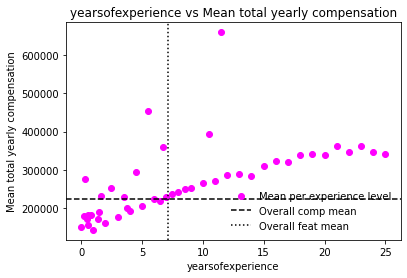

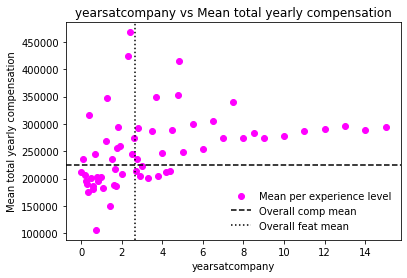

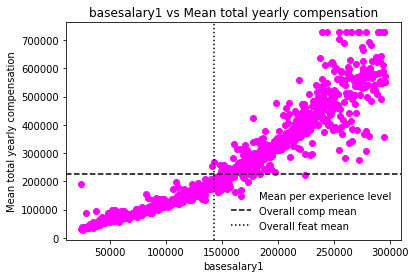

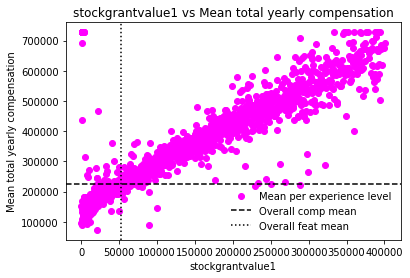

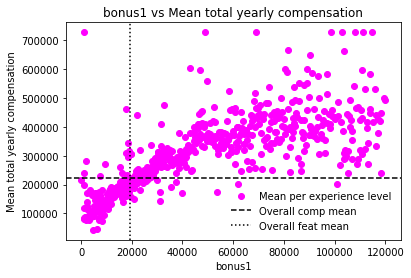

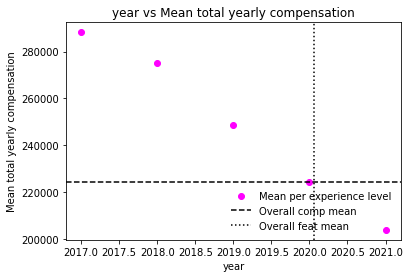

In [ ]:
# Transform date1 into year to see if totalyearlycompensation changed over time in 2021 dollars
df41=df40.withColumn('year',year(df40.date1))

# Get overall mean of totalyearlycompensation1 for reference on charts
ave_comp=df41.agg(avg('totalyearlycompensation1')).head()[0]

# Plot each continous feature as a scatterplot
for i in ['yearsofexperience','yearsatcompany','basesalary1','stockgrantvalue1','bonus1','year']:
    # Calculate mean for feature
    ave_feat=df41.agg(avg(i)).head()[0]
    # Calculate mean for each level of feature
    temp=df41.groupBy(i).mean('totalyearlycompensation1')
    temp1=temp.withColumnRenamed("avg(totalyearlycompensation1)","mean_totalyearlycompensation1")
    temp2=temp1.sort(temp1.mean_totalyearlycompensation1)
    # Create lists for x and y inputs for plotting
    x=[val[i] for val in temp2.select(i).collect()]
    y=[val.mean_totalyearlycompensation1 for val in temp2.select('mean_totalyearlycompensation1').collect()]
    # Plot and label chart
    plt.scatter(x,y,color='magenta')
    plt.ylabel('Mean total yearly compensation')
    plt.xlabel(i)
    plt.title(str(i)+' vs Mean total yearly compensation')
    # Plot horizontal line for overall average of total yearly compensation
    plt.axhline(ave_comp, color='black',linewidth=1.5,linestyle='dashed')
    plt.axvline(ave_feat, color='black',linewidth=1.5,linestyle='dotted')
    plt.legend(['Mean per experience level', 'Overall comp mean', 'Overall feat mean'],loc='lower right',frameon=False)
    plt.show()

<font color='darkblue'>

Observations:


- Features of 'yearsofexperience' and 'yearsatcompany' show high variation in total yearly compensation for the first few years of a person's career or company tenure before becoming more linear after about 8 years in both cases


- 'basesalary1' and 'stockgrantvalue1' have strong monotonic relationships with total yearly compensation. 'basesalary1' does not appear to have a linear relationship with total yearly compensation which may be due to people on higher salaries attracting higher extras like bonuses and stock options


- There is high variance in 'bonus1' for people with salaries above the mean


- 'year' shows a strong montonic relationship and highlights total yearly compensation decreasing over time in terms of 2021 USD

</font>

#### ii. Calculate pairwise correlations

<font color='darkblue'>

Here we want to:

- Calculate the Pearson correlation score for each pair of features (including the target feature) using the PySpark correlation package
    
    
- Use the scores to test the following hypotheses for any pair of features:

     H0 - there is no correlation between the two features \
     H1 - there is correlation between the two features
      
  To do this we have to use Python scipy to get the required p-values as there is no equivalent capability in PySpark
  
</font>

Get pairwise correlation scores:

In [ ]:
# Convert continuous features from double into float
df41_cts=df41.select(*(col(c).cast("float").alias(c) for c in df41.select('totalyearlycompensation1','yearsofexperience', \
                                                                          'yearsatcompany','basesalary1', \
                                                                          'stockgrantvalue1','bonus1','year').columns))
# Convert features into required vector column using assembler
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df41_cts.columns, outputCol=vector_col)
df_vector = assembler.transform(df41_cts).select(vector_col)

# Compute the pairwise Pearson correlations coefficient
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=df41_cts.columns, index=df41_cts.columns)
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_2241705/2531100926.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,totalyearlycompensation1,yearsofexperience,yearsatcompany,basesalary1,stockgrantvalue1,bonus1,year
totalyearlycompensation1,1.00,0.45,0.18,0.74,0.82,0.52,-0.16
yearsofexperience,0.45,1.00,0.52,0.41,0.30,0.29,0.00
yearsatcompany,0.18,0.52,1.00,0.16,0.10,0.12,-0.01
basesalary1,0.74,0.41,0.16,1.00,0.56,0.51,-0.05
stockgrantvalue1,0.82,0.30,0.10,0.56,1.00,0.31,-0.06
bonus1,0.52,0.29,0.12,0.51,0.31,1.00,-0.04
year,-0.16,0.00,-0.01,-0.05,-0.06,-0.04,1.00


<font color='darkblue'>

Observations:

- The features that logically make up a person's total yearly compensation package - 'stockgrantvalue1', 'basesalary1_rnd' and 'bonus1_rnd' - are all highly correlated with the 'totalyearlycompensation1' (0.82, 0.74 and 0.52 respectively) while also having moderate levels of pairwise correlation


- The feature 'year' has a very low (albeit negative) correlation with the target feature and hence they may not be related even though the plot above suggests a relationship. This feature also has no significant pairwise correlation with any feature


- The features 'yearsofexpereince_rnd' and 'yearsatcompany_rnd' have a moderate level of pairwise correlation and could be collinear (0.52). The rest do not appear highly correlated
    
</font>

Test the pairwise correlations to accept or reject the null hypothesis:

In [ ]:
# Loop through the different pairwise combinations and use scipy to highlight p-values > 0.01
for i in ['totalyearlycompensation1','yearsofexperience','yearsatcompany','basesalary1','stockgrantvalue1','bonus1','year']:
    for j in ['totalyearlycompensation1','yearsofexperience','yearsatcompany','basesalary1','stockgrantvalue1','bonus1','year']:
        # Need to flatten the required columns into a python list
        x=df41.select(i).rdd.flatMap(lambda z: z).collect()
        y=df41.select(j).rdd.flatMap(lambda z: z).collect()
        # Calculate and print the correlation coefficient and p-value for each pair of features if p=value>0.05
        if pearsonr(x,y)[1]>0.01:
            print(str(i),str(j),pearsonr(x,y))

yearsofexperience year (0.00011267412624882113, 0.9775060882207242)
year yearsofexperience (0.00011267412624882113, 0.9775060882207242)


<font color='darkblue'>

Observations:

- The scipy calculations for correlation coefficients match those of PySpark (noted when the 'if' clause in the code above is removed)
    
    
- The p-values are near zero for almost all pairs so are statistically significant. There is very strong evidence to accept H1 of there being correlation between the pairs of features, i.e some form of relationship, including that of each feature and the target 'totalyearlycompensation1'
    
    
- The only exception is the pair of features 'year' and 'yearsofexperience'. They have a very high p-value and even at the 5% level of significance we cannot reject H0, i.e. there is no correlation between the two features
    
</font>

#### iii. Findings

<font color='darkblue'>

- The features that logically make up a person's total yearly compensation package - 'stockgrantvalue1', 'basesalary1_rnd' and 'bonus1_rnd - are all highly correlated with the 'totalyearlycompensation1' (0.82, 0.74 and 0.52 respectively) while also having moderate levels of pairwise correlation


- The feature 'year' has a very low (albeit negative) correlation with the target feature and hence they may not be related even though the plot above suggests a relationship. This feature also has no significant pairwise correlation with any feature


- The features 'yearsofexpereince_rnd' and 'yearsatcompany_rnd' have a moderate level of pairwise correlation and could be collinear (0.52). The rest do not appear highly correlated


- As we are interested in understanding which characteristics (e.g. qualification, company, gender, etc) drive levels of total yearly compensation the features of 'stockgrantvalue1', 'basesalary1_rnd' and 'bonus1_rnd' will be removed as they explicitly define the target feature. While 'bonus1_rnd' has lower correlation with the target feature, this appears to be due to its high  variance for those people in the top 20% of total yearly compensation and so its correlation with the target feature would be significantly high for 80% of people. These features also all appear to be moderately collinear

    
- The correlation scores do not indicate high levels of collinearity (asides for the pair of 'yearsofexpereince_rnd' and 'yearsatcompany_rnd' with a moderate score) so none will be dropped on this basis

    
- Considering the remaining features, the hypothesis testing has found most features are correlated to each other to some extent, including the target, but as the scores are relatively low we cannot consider the features collinear. We will drop 'year' as while tests indicated correlation with other features (asides 'yearsofexperience') the scores are very small
    
</font>

#### iv. Action
Drop 'basesalary1', 'bonus1', 'stockgrantvalue1' and 'year'

df41=df41.drop('basesalary1','bonus1','stockgrantvalue1','year')

### b. Categorical features

<font color='darkblue'>

Here we want to:
    
- Visualize the relationship between each feature and the target feature
- Identify features which are considered redundant due to its levels not differentiating total yearly compensation

</font>

#### i. Plot the relationship between each feature and the target

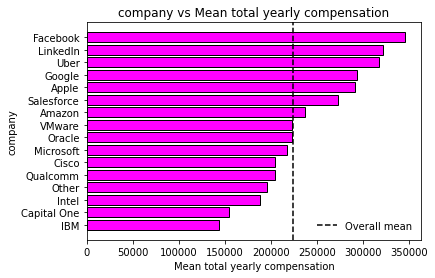

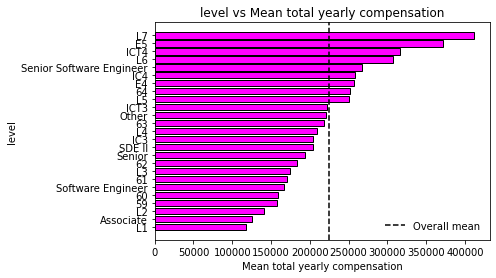

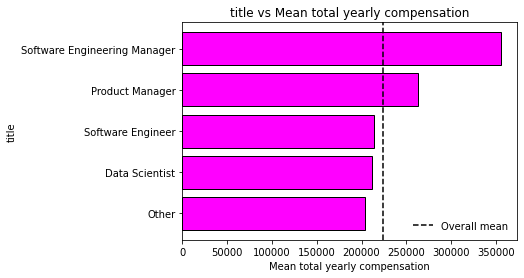

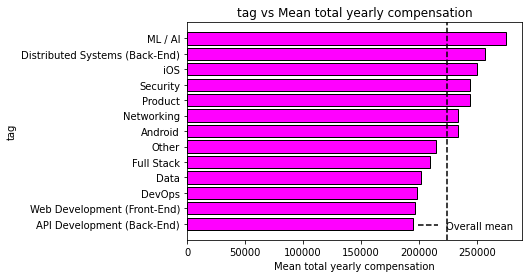

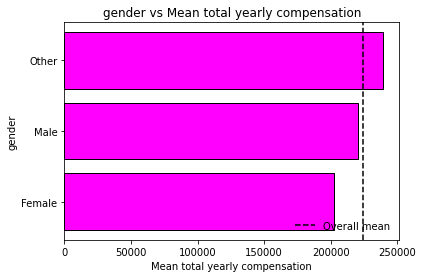

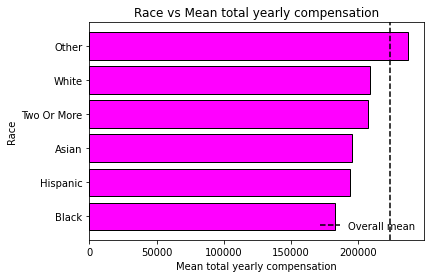

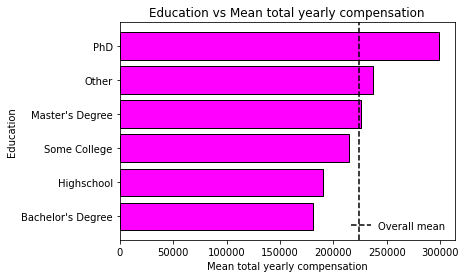

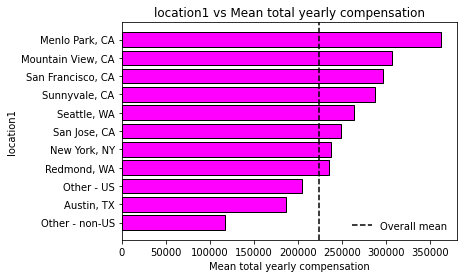

In [ ]:
for i in ['company','level','title','tag','gender','Race','Education','location1']:
    # Calculate mean for each level of feature
    temp=df41.groupBy(i).mean('totalyearlycompensation1')
    temp1=temp.withColumnRenamed("avg(totalyearlycompensation1)","mean_totalyearlycompensation1")
    temp2=temp1.sort(temp1.mean_totalyearlycompensation1)
    # Create lists for x and y inputs for plotting
    y=[val.mean_totalyearlycompensation1 for val in temp2.select('mean_totalyearlycompensation1').collect()]
    x=[val[i] for val in temp2.select(i).collect()]
    # Plot and label chart
    plt.barh(x,y,color=['magenta'],edgecolor='black')
    plt.ylabel(i)
    plt.xlabel('Mean total yearly compensation')
    plt.title(str(i)+' vs Mean total yearly compensation')
    # Plot vertical line for overall average of total yearly compensation
    plt.axvline(ave_comp, color='black',linewidth=1.5,linestyle='dashed')
    plt.legend(['Overall mean'],loc='lower right',frameon=False)
    plt.show()

<font color='darkblue'>

Observations:

Noticeable differentiation per level of each feature in terms of mean total yearly compensation, including:
- Facebook, LinkedIn, Uber, Google and Apple comprising the highest paid employees
- Hard to disseminate the differences by level due to them being related to different companies and their respective scales
- People with 'Manager' in their title earn the most
- Tags for ML/AI earn the most while those of Web/API development earn the lowest
- Where gender is known, male employees earn more than females
- Where race is known, white and mixed race people earn more than others
- Where education is known, employees with a doctorate earn the most followed by Masters and Bachelor degree holders (the other categories are too small to infer from)
- Employees who work in California earn the most compared to those in other parts of the US or rest of the world
    
</font>

#### ii. Confirm if different levels of a feature have a measurable effect on the target

<font color='darkblue'>

Here we want to:

Confirm the findings above by using the statistical test of one-way ANOVA where for the hypotheses of:

  H0: mean(i)=mean(j) for any i,j which are levels of the categorical feature \
  H1: mean(i)<>mean(j) for any i,j which are levels of the categorical feature
    
</font>

As the version of Spark on the cluster does not include the algorithm 'UnivariateFeatureSelector' I have created the following function in PySpark:

In [ ]:
def f_stat(cat_feat):

    """
    For the Spark dataframe df41 return the F test statistic of a one-way ANOVA test for selected categorical features versus
    the continuous feature totalyearlycompensation1

    Input:
    cat_feat: df41 column which is categorical

    Returns:
    F test statistics calculated from the actual data
    Required degrees of freedom to be able to test hypothesis of categorical level means being same (H0) or different (H1):
      SSR degrees of freedom
      SSE degrees of freedom
    """

    # Step 1: Get required mean values

    # Get overall mean for 'totalyearlycompensation1'
    overall_mean=df41.select(mean('totalyearlycompensation1')).take(1)[0][0]
    # Get mean 'totalyearlycompensation1' for each level of categorical feature
    level_means=df41.groupby(cat_feat).mean('totalyearlycompensation1').withColumnRenamed("avg(totalyearlycompensation1)", \
                                                                                          "level_mean")

    # Step 2: Calculate regression sum of squares (SSR)

    # Add number of employees per level of categorical feature to level_means
    level_size=df41.groupby(cat_feat).count().withColumnRenamed("count","level_size")
    agg_temp=level_size.join(level_means,cat_feat)
    # Add overall_mean for each row
    agg_temp=agg_temp.withColumn("overall_mean",lit(overall_mean))
    # Derive SSR
    agg_temp=agg_temp.withColumn('n x ([overall_mean-level_mean]^2)', \
                                 agg_temp['level_size']*((agg_temp['overall_mean']-agg_temp['level_mean'])**2))
    ssr=agg_temp.select(sum('n x ([overall_mean-level_mean]^2)')).take(1)[0][0]

    # Step 3: Calculate error sum of squares (SSE)

    # For each employee record in df41 add level_size, level_mean & overall_mean
    df41_temp=agg_temp.join(df41,df41[cat_feat]==agg_temp[cat_feat]).drop(agg_temp[cat_feat]).drop(agg_temp['n x ([overall_mean-level_mean]^2)'])

    # Derive SSE
    df41_temp=df41_temp.withColumn("(totalyearlycompensation1-level_mean)^2",(df41_temp['totalyearlycompensation1']-df41_temp['level_mean'])**2)
    sse=df41_temp.select(sum('(totalyearlycompensation1-level_mean)^2')).take(1)[0][0]

    # Step 4: ANOVA table

    # Get count of levels in categorical feature
    k=df41.select(countDistinct(cat_feat)).take(1)[0][0]
    # Get count of overall number of employees
    n=df41.count()
    # Get required degrees of freedom
    ssr_dof=k-1
    sse_dof=n-k
    # Calculate f statistic
    f_stat=(ssr/ssr_dof)/(sse/sse_dof)

    return f_stat, ssr_dof, sse_dof

# Get F test statistic for each categorical feature in df41
f_stats={}
for i in ['company','level','title','tag','gender','Race','Education','location1']:
    f=f_stat(i)
    f_stats[i]=f

# Print out results
f_stats

{'company': (587.5968413889013, 15, 62607),
 'level': (361.3741209042745, 24, 62598),
 'title': (1268.6332967719402, 4, 62618),
 'tag': (197.5976585715255, 12, 62610),
 'gender': (258.39668993921646, 2, 62620),
 'Race': (260.7413654636198, 5, 62617),
 'Education': (489.24417697873855, 5, 62617),
 'location1': (1733.645928485597, 10, 62612)}

Get critical values (F) from Eton's tables @ 5% significance level:

<font color='darkblue'>

Observation:
    
Each critical value is significantly less than its respective test statistic so we reject H0 and accept H1 that mean total yearly compensation1 is significantly different across the levels of each categorical feature
    
</font>

Spot check that user defined function produces correct results for statistic F test using scipy (by example):

In [ ]:
f_oneway(df41.select('totalyearlycompensation1').where(df41['gender']=='Female').collect(),
         df41.select('totalyearlycompensation1').where(df41['gender']=='Other').collect(),
         df41.select('totalyearlycompensation1').where(df41['gender']=='Male').collect())

F_onewayResult(statistic=array([258.39668994]), pvalue=array([1.73892048e-112]))

Same result achieved above for feature 'gender'

#### iii. Findings

<font color='darkblue'>

- All categorical features have statistically significant differences in their mean total year compensation
- Keep all the categorical features

</font>

In [ ]:
# Check size
print((df41.count(),len(df41.columns)))

(62623, 17)


Save the resulting dataframe to HDFS

In [ ]:
df41.write.option("header","true").parquet('hdfs:///user/jmccl001/cw2/df41',mode="overwrite")

Check dataframe is on HDFS

In [ ]:
!/opt/hadoop/current/bin/hadoop fs -ls cw2/

Found 3 items
-rwxr-xr-x   3 jmccl001 users   12781635 2022-09-06 11:17 cw2/Levels_Fyi_Salary_Data.csv
drwxr-xr-x   - jmccl001 users          0 2022-09-10 22:03 cw2/df40
drwxr-xr-x   - jmccl001 users          0 2022-09-10 22:04 cw2/df41


## 8. Predicting a STEM professional's 'total yearly compensation'

<font color='darkblue'>
  
This section undertakes model building using different algorithms and seeks to find a 'best' model to predict a STEM professional's total yearly compensation
    
The steps involves are:
- Create transformers to prepare the data as per above and others required such as One Hot Encoding
- Create estimators for different types of models
- Build and evaluate the models
- Develop the best model

</font>

### a. Get source data

<font color='darkblue'>
We need to build our pipeline off original source data so that it applies all the required data wrangling
</font>

In [ ]:
# Infer the data types and use first row as a header row
df=spark.read.csv('hdfs:///user/jmccl001/cw2/Levels_Fyi_Salary_Data.csv', header=True, inferSchema=True)

# Check number of partitions
df.rdd.getNumPartitions()

2

### b. Create transformers to prepare data ahead of modelling

<font color='darkblue'>

Here we want to define all the required transformers that will be used in the pipeline

The following 11 features from the source data are used to create the feature vector:
  
   01. company
   02. Level
   03. Title
   04. Tag
   05. Gender
   06. Race
   07. Education
   08. Location
   09. Years of experience
   10. Years at company
   11. Year
    
Note that when One Hot Encoding is applied this expands to 80 numeric features in total

</font>

#### i. SQL data preparation

<font color='darkblue'>

This transformer wrangles the data into shape as per all of the cleaning and preparation steps above in data audit and EDA sections

</font>

In [ ]:
# Actions undertaken:
# Remove any records with any missing values
# Subset to required features
# Format their column types
# Collapse levels for categorical features
# Clip continuous features
# Prepare the target feature ahead of model build

dataprep_sql=SQLTransformer(
statement="SELECT \
           CASE \
             WHEN company NOT IN ('Amazon','Microsoft','Google','Facebook','Apple','Oracle','Salesforce','Intel','IBM','Cisco', \
                                  'Uber','Capital One','LinkedIn','VMware','Qualcomm') THEN 'Other' \
             WHEN company IS NULL THEN 'Other' \
             ELSE company \
             END as company, \
           CASE \
             WHEN level NOT IN ('L4','L5','L3','L6','Senior Software Engineer','L2','Senior','L7','L1','62','63','E5','ICT4', \
                                'Software Engineer','61','IC3','IC4','E4','ICT3','60','64','SDE II','59','Associate') THEN 'Other' \
             WHEN level IS NULL THEN 'Other' \
             ELSE level \
             END as level, \
           CASE \
             WHEN title NOT IN ('Software Engineer','Product Manager','Software Engineering Manager','Data Scientist') THEN 'Other' \
             WHEN title IS NULL then 'Other' \
             ELSE title \
             END as title, \
           CASE \
             WHEN tag NOT IN ('Full Stack','Distributed Systems (Back-End)','API Development (Back-End)','ML / AI','Web Development (Front-End)','Product','Data','DevOps','Security','Networking','iOS','Android') THEN 'Other' \
             WHEN tag IS NULL then 'Other' \
             ELSE tag \
             END AS tag, \
           CASE \
             WHEN gender NOT IN ('Male','Female','Other') THEN 'Other' \
             WHEN gender IS NULL then 'Other' \
             ELSE gender \
             END AS gender, \
           cast(rowNumber as integer) as rowNumber, \
           CASE \
             WHEN Race NOT IN ('White','Black','Asian','Hispanic','Two Or More') THEN 'Other' \
             WHEN Race IS NULL then 'Other' \
             ELSE Race \
             END as Race, \
           CASE \
             WHEN Education not in ('PhD','Master\\'s Degree','Bachelor\\'s Degree','Some College','Highschool') THEN 'Other' \
             WHEN Education IS NULL then 'Other' \
             ELSE Education \
             END as Education, \
           CASE \
             WHEN cast(totalyearlycompensation as integer)>=727486 then 727486 \
             ELSE cast(totalyearlycompensation as integer) \
             END as totalyearlycompensation, \
           CASE \
             WHEN location not in ('Seattle, WA','San Francisco, CA','New York, NY','Redmond, WA','Mountain View, CA','Sunnyvale, CA','San Jose, CA','Austin, TX','Menlo Park, CA') and ((split(location,',')[2]==' United States') or (split(location,',')[2] IS NULL)) THEN 'Other - US' \
             WHEN location not in ('Seattle, WA','San Francisco, CA','New York, NY','Redmond, WA','Mountain View, CA','Sunnyvale, CA','San Jose, CA','Austin, TX','Menlo Park, CA') and split(location,',')[2]!=' United States' THEN 'Other - non-US' \
             WHEN location IS NULL then 'Other - non-US' \
             ELSE location \
             END as location, \
           CASE \
             WHEN cast(yearsofexperience as float)>=25 THEN 25 \
             ELSE cast(yearsofexperience as float) \
             END as yearsofexperience, \
           CASE \
             WHEN cast(yearsatcompany as float)>=15 THEN 15 \
             ELSE cast(yearsatcompany as float) \
             END as yearsatcompany, \
           case \
             WHEN cast(split(split(timestamp, '/')[2],' ')[0] as integer) IS NULL then 2017 \
             ELSE cast(split(split(timestamp, '/')[2],' ')[0] as integer) \
             END as year \
           FROM __THIS__ \
           where \
           timestamp is not null and \
           company is not null and \
           level is not null and \
           title is not null and \
           totalyearlycompensation is not null and \
           location is not null and \
           yearsofexperience is not null and \
           yearsatcompany is not null and \
           tag is not null and \
           basesalary is not null and \
           stockgrantvalue is not null and \
           bonus is not null and \
           gender is not null and \
           otherdetails is not null and \
           cityid is not null and \
           dmaid is not null and \
           rowNumber is not null and \
           Masters_Degree is not null and \
           Bachelors_Degree is not null and \
           Doctorate_Degree is not null and \
           Highschool is not null and \
           Some_College is not null and \
           Race_Asian is not null and \
           Race_White is not null and \
           Race_Two_Or_More  is not null and \
           Race_Black is not null and \
           Race_Hispanic is not null and \
           Race is not null and \
           Education is not null")

#### ii. One Hot Encoding of categorical features

<font color='darkblue'>

This transformer converts the levels of each categorical feature into an integer \
This is necessary for ML algorithms that run only on numerical data such as linear regression \
The OneHotEncoder method can only accept integer types (Drabas et al, 2017) so the categorical features which are string types need to be converted to integer types and we can do this using the StringIndexer transformation \
The StringIndexer transformer will also help us with any unseen data values in new data by employing its 'skip unseen values' option so that only values seen by the model will be considered for scoring of new data

</font>

Define StringIndexer transformer for categorical features:

In [ ]:
cat_feat_indexer=StringIndexer(inputCols=['company','level','title','tag','gender','Race','Education','location'],
                               outputCols=['company_index','level_index','title_index','tag_index','gender_index','Race_index', \
                                          'Education_index','location_index'],
                               handleInvalid='skip')

Define One Hot Encoder transformer for categorical features:

In [ ]:
cat_feat_ohe=OneHotEncoder(inputCols=cat_feat_indexer.getOutputCols(),
                           outputCols=['company_index_vec','level_index_vec','title_index_vec','tag_index_vec', \
                                       'gender_index_vec', 'Race_index_vec','Education_index_vec','location_index_vec'])

#### iii. Create single column feature

<font color='darkblue'>

This transformer brings together all the feature values per person into one 'feature' vector as Spark ML algorithms only accept a single column feature \
Here we only include the independent features and exclude the target feature (totalyearlycompensation) or the identifier feature (rowNumber)

</font>

In [ ]:
all_feat_col=VectorAssembler(inputCols=cat_feat_ohe.getOutputCols()+['yearsofexperience','yearsatcompany','year'],
                             outputCol='features')

#### iv. Standardise the feature vector

<font color='darkblue'>

This transformer standardizes the components of the feature vector \
Some of the original features are of different measures so we want to scale them so we can:
- use Gradient Descent-based algorithms which are sensitive to the range of the data points (Pulagam, 2020)
- make interpretation of results easier to understand

</font>

In [ ]:
feat_scaler=MaxAbsScaler(inputCol=all_feat_col.getOutputCol(),outputCol="features_scaled")

### c. Create model estimators

<font color='darkblue'>

This section is used to build these trhee Spark ML estimators which will be used to create models to predict 'totalyearlycompensation' from raw data:
    
- Linear regression
- Random Forest
- Gradient Boosted Trees Regression
    
The three models which will be evaluated on the test data \
Standard parameters have been selected for initial model builds which will be reconsidered later with hyperparameter tuning

</font>

#### i. Linear regression

In [ ]:
lr=LinearRegression(maxIter=20,
                    regParam=0.3,
                    elasticNetParam=0.8,
                    solver='auto',
                    featuresCol='features_scaled',
                    labelCol='totalyearlycompensation')

#### ii. Random forest

In [ ]:
rf=RandomForestRegressor(featuresCol="features_scaled",
                         labelCol='totalyearlycompensation',
                         numTrees=100,
                         maxDepth=15)

#### iii. Gradient-boosted tree regression

In [ ]:
gbt=GBTRegressor(featuresCol='features_scaled',
                 labelCol='totalyearlycompensation',
                 maxIter=200)

### d. Build and evaluate models

<font color='darkblue'>

This section creates a Spark ML pipeline comprising all of the required transformers and estimators \
The 'dataprep_sql transformer is required to be underertaken ahead of the pipeline as the pipeline only considers the training data and the evaluation which occurs after the pipeline is run needs to consider the test data prepared as per the training data \
As per normal model development their performance is evaluated on the test data and the metrics RMSE and R2 are used to compare across models

</font>

#### i. Prepare the data as required from the data audit and cleaning steps above using the SQL transformer

In [ ]:
df_prep=dataprep_sql.transform(df)

#### ii. Split the resulting dataframe data into training and test dataframes

In [ ]:
df_train, df_test=df_prep.randomSplit([0.7,0.3],seed=666)

#### iii. Build models by applying the transformers and estimators to the training data. Evaluate each using the test data

In [ ]:
for i in [lr, rf, gbt]:
    # Build model
    pipeline=Pipeline(stages=[cat_feat_indexer, cat_feat_ohe, all_feat_col, feat_scaler, i])
    model=pipeline.fit(df_train)
    # Evaluate model
    test_model=model.transform(df_test)
    evaluator=ev.RegressionEvaluator(
                                     predictionCol="prediction",
                                     labelCol="totalyearlycompensation"
                                    )
    # RMSE is the standard deviation of the residuals (prediction errors).
    print(str(i),':','RMSE=',evaluator.evaluate(test_model,{evaluator.metricName: 'rmse'}))
    # R2 is the percentage of variability explained by the model
    print(str(i),':','R2=',evaluator.evaluate(test_model,{evaluator.metricName: 'r2'}))

LinearRegression_694a05742ad1 : RMSE= 83224.80584913821


LinearRegression_694a05742ad1 : R2= 0.5436064102010797


RandomForestRegressor_a0b67637a7e1 : RMSE= 74696.12064233108


RandomForestRegressor_a0b67637a7e1 : R2= 0.6323538274148068


GBTRegressor_ed0c20ef3e6b : RMSE= 73383.46986446861


GBTRegressor_ed0c20ef3e6b : R2= 0.6451617401413061


#### iv. Evaluating the RMSE


<font color='darkblue'>

RMSE scores for the models are all within the standard deviation of the overall mean of 'totalyearlycompensation' proving the residuals of the predictions may have a similar distribution to that of 'totalyearlycompensation'
    
</font>

In [ ]:
df.select(stddev(col('totalyearlycompensation')).alias('standard deviation')).show()

+------------------+
|standard deviation|
+------------------+
|138036.70471598816|
+------------------+



#### v. Findings

<font color='darkblue'>
    
    
The GBTRegressor is the best performing model with the lowest RMSE and the highest R2 \
But as it only accounts for 64% of the variation we can try to improve this by using only the best features - to avoid overfitting - and to further optimise the model by tuning its hyperparameters
    
    
</font>

### e. Build best model

<font color='darkblue'>
    
In this section the GBTRegressor model is developed further to see if the model performance can be improved from RMSE of £73K and R2 of 64% \

We do this by:
- Reducing the number of features
- Optimizing hyperparamters

</font>

#### i. Reduce the number of features

<font color='darkblue'>

Here we will try to reduce the number of features in the model from 80 to a smaller number without comprising model performance \
A model with a high number of features can cause overfitting and unnecessary complexity \
In the absence of the Spark ML 'UnivariateFeatureSelector' function in this version of Spark the number of features will be reduced using the GBTRegressor 'feature importance' rankings

</font>

Rank features by GBTRegressor 'feature importance'

<font color='darkblue'>
    
    
The outputs of PySpark feature importance method are not easily interpretable as column-level names need to be added to the feature vector rows. This proved to be a difficult exercise so in the end the following function created by Timothy Lin (Lin, 2018) was used.   

The top 20 features show 'years of experience' and 'years at company' are significant drivers of total yearly compensation. Interestingly, 'location' outside of California drive higher compensation. 'title' involving software engineering contributes highly as does those who's 'company' is Google, those who have the tag of 'AI/ML' or hold a PhD
    
'year', 'Race' and 'gender' are quite low in the feature importance rankings
    
    
</font>

In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

feat_import=ExtractFeatureImp(model.stages[-1].featureImportances,test_model,"features")
feat_import.head(20)

,idx,name,score
0,77,yearsofexperience,0.183915
71,68,location_index_vec_Other - non-US,0.057900
45,42,title_index_vec_Software Engineering Manager,0.054704
1,78,yearsatcompany,0.050050
6,3,company_index_vec_Google,0.045463
70,67,location_index_vec_Other - US,0.040258
43,40,title_index_vec_Other,0.039973
18,15,level_index_vec_Other,0.036373
73,70,"location_index_vec_San Francisco, CA",0.034121
7,4,company_index_vec_Facebook,0.030622


<font color='darkblue'>
   
Rank of original features by their highest ranked level:
    
1. yearsofexperience
2. location
3. title
4. yearsatcompany
5. company
6. level
7. tag
8. Education
9. year
10. gender
11. race
    
Plotting the feature importance we can see 21 features as being above the mean score:

</font>

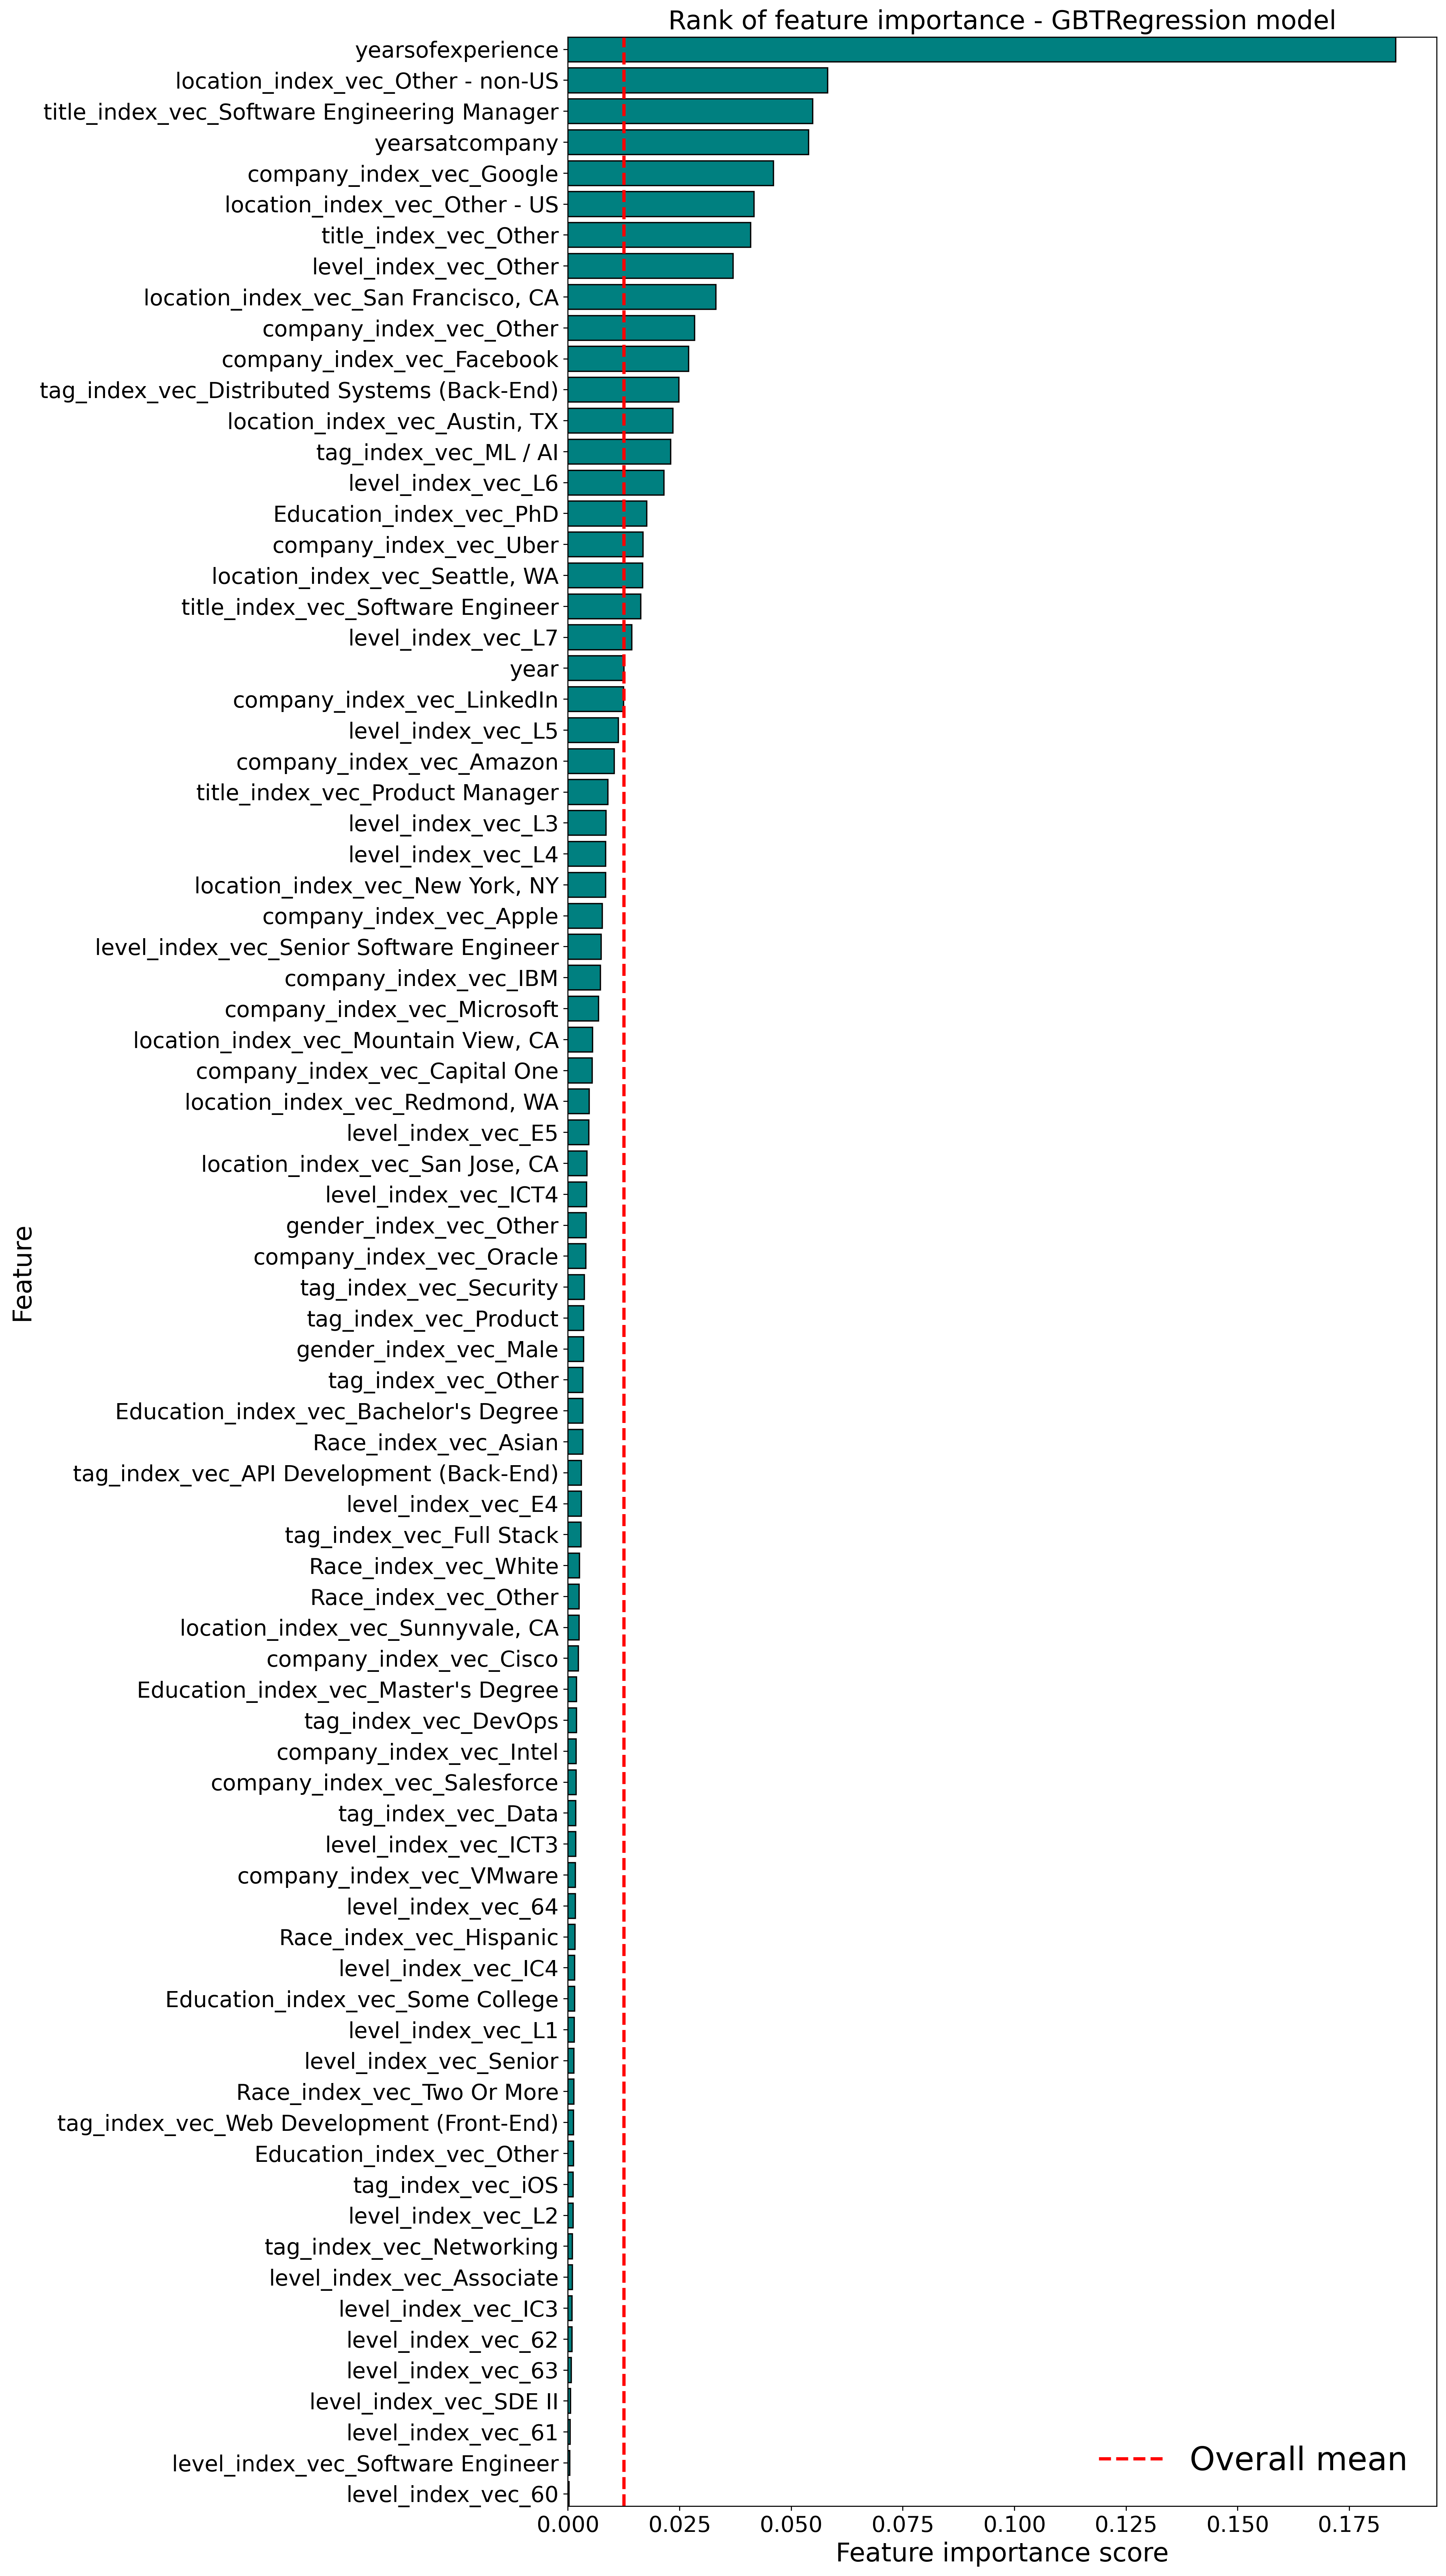

In [ ]:
figure(figsize=(12,35), dpi=250)
plt.margins(y=0)
mean=feat_import.score.mean()
feat_import.sort_values(by='score',ascending=True,inplace=True)
plt.barh(feat_import.name,feat_import.score,color=['teal'],edgecolor='black')
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.ylabel('Feature',fontsize=20)
plt.xlabel('Feature importance score',fontsize=20)
plt.title('Rank of feature importance - GBTRegression model',fontsize=20)
# Plot vertical line for overall average of total yearly compensation
plt.axvline(mean, color='red',linewidth=2.5,linestyle='dashed')
plt.legend(['Overall mean'],loc='lower right',frameon=False,fontsize=25)
plt.show()

<font color='darkblue'>
To find an optimum number of features to retain we can build and evaluate models on the top 20, 30, 40, 50, 60, 70 & 80 features based on their feature importances and see how the RMSE and R2 scores change
    
Here 'VectorSlicer' is used to create a transformer which selects a subset of features, in this the top i features based on their feature importance rank
</font>

<font color='boldbrightred'>
User note:

The following step takes ~13 minute to run so could be ignored as it just provides insight on an optimal number of features and is not required to be run for further steps
</font>

In [ ]:
for i in range(20,81,10):

    # Identify top i features from GBT model based on score rank
    feat_import.sort_values(by='score', ascending=False,inplace=True)
    varidx= [x for x in feat_import['idx'][0:i]]

    # Define slicer transformation
    drop_feats=VectorSlicer(inputCol="features_scaled", outputCol="features1", indices=varidx)

    # Revise model estimator to include revised input column following slicer transformer
    gbt1=GBTRegressor(featuresCol='features1',
                      labelCol='totalyearlycompensation',
                      maxIter=200)

    # Revise pipeline to include slicer transformer
    pipeline1=Pipeline(stages=[cat_feat_indexer, cat_feat_ohe, all_feat_col, feat_scaler, drop_feats, gbt1])

    # Rebuild model with new pipeline
    model1=pipeline1.fit(df_train)

    # Evaluate revised model
    test_model1=model1.transform(df_test)
    print(str(i),'features:','RMSE=',evaluator.evaluate(test_model1,{evaluator.metricName: 'rmse'}), \
          'R2=',evaluator.evaluate(test_model1,{evaluator.metricName: 'r2'}))

20 features: RMSE= 79384.53002751007 R2= 0.5847537581133877


30 features: RMSE= 75178.50325369753 R2= 0.6275900253853228


40 features: RMSE= 73954.13668010182 R2= 0.639621479658026


50 features: RMSE= 73570.75745783106 R2= 0.6433482088759429


60 features: RMSE= 73602.57567120728 R2= 0.6430396494127739


70 features: RMSE= 73459.2049373528 R2= 0.6444289438055042


80 features: RMSE= 73312.38450609444 R2= 0.6458488591333997


<font color='darkblue'>

Findings:
    
Little gain lost in performance after 40 features (R2 with 40 features=64% while R2 with 80 features=65%) so can retain the 40 features with highest feature importance to avoid an overly complicated model and one at risk of overfitting

Now we will look to improve R2 using hyperparameter tuning
    
</font>

#### ii. Optimise hyperparameters

<font color='darkblue'>

Here we will try to optimise the hyperparameters used for the GBTRegressor model to help improve the performance of the model

The parameters to be considered are:
    
maxDepth - maximum number of levels for each tree \
maxIter - maximum number of tree in the ensemble
    
A grid search approach will be undertaken
</font>

Get training and test data

In [ ]:
# Use original source data
df_prep=dataprep_sql.transform(df)
df_train, df_test=df_prep.randomSplit([0.7,0.3],seed=666)

Get indices of the top 40 features to be retained based on EDA above

In [ ]:
feat_import.sort_values(by='score',ascending=False,inplace=True)
varidx= [x for x in feat_import['idx'][0:40]]

Define the slicer transformer to subset the data for the required 40 features \
This transformer was not previously defined as a standalone transformer like the others (just as part of a loop above)

In [ ]:
drop_feats=VectorSlicer(inputCol="features_scaled", outputCol="features1", indices=varidx)

Define the model estimator

In [ ]:
gbt2=GBTRegressor(featuresCol='features1',
                  labelCol='totalyearlycompensation')

Define the hyperparameter grid to be used

In [ ]:
paramGrid=ParamGridBuilder()\
  .addGrid(gbt2.maxDepth, [5, 10])\
  .addGrid(gbt2.maxIter, [150, 200])\
  .build()

Define the evaluation metric to be used in the CrossValidator

In [ ]:
rmse=RegressionEvaluator(metricName="rmse",labelCol=gbt2.getLabelCol(),predictionCol=gbt2.getPredictionCol())

Define the CrossValidator to perform the model tuning and to find the best model based on the evaluation metric above

In [ ]:
cv=CrossValidator(estimator=gbt2,evaluator=rmse,estimatorParamMaps=paramGrid)

Create the revised pipeline with hyperparameter tuning

In [ ]:
pipeline2=Pipeline(stages=[cat_feat_indexer,cat_feat_ohe,all_feat_col,feat_scaler,drop_feats,cv])

Run the pipeline on the training data to return the best model

<font color='boldbrightred'>
User note:

The following step takes ~45 minute to run so could be ignored if as the results are detailed below

</font>

In [ ]:
pipelineModel=pipeline2.fit(df_train)

Use the pipeline to transform the test data and get predictions

In [ ]:
test_preds=pipelineModel.transform(df_test)

Get evaluation statistics for the best model based on test data predictions

In [ ]:
print('RMSE=',evaluator.evaluate(test_preds,{evaluator.metricName: 'rmse'}))
print('R2=',evaluator.evaluate(test_preds,{evaluator.metricName: 'r2'}))

RMSE= 73954.13668010182


R2= 0.639621479658026


<font color='darkblue'>

Only 0.5% improvement. Because of error messages about running out of memory a more exhaustive grid search could not be undertaken
    
 </font>

Calculate the overall mean of the residuals

In [ ]:
test_preds1=test_preds.withColumn("residual",(col("totalyearlycompensation")-col("prediction")))
test_preds1.agg({'residual': 'mean'}).show()

+------------------+
|     avg(residual)|
+------------------+
|-617.5427231234352|
+------------------+



<font color='darkblue'>
    
Mean residual is only -£618 which is less than 0.2% of the mean of 'totalyearlycompensation'
    
</font>

The distribution of the residuals (predicted values minus actual values) is a diagnostic for measuring model performance

Plot actuals versus predicted

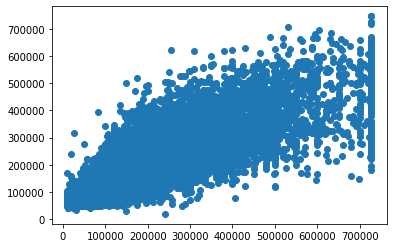

In [ ]:
x1=test_preds1.rdd.map(lambda x: x['totalyearlycompensation']).collect()
x1_rnd=np.round(x1)
y=test_preds1.rdd.map(lambda x: x['prediction']).collect()
y_rnd=np.round(y)
plt.scatter(x1_rnd,y_rnd)
plt.show()

<font color='darkblue'>

Plot shows a linear trend but lots of variation in prediction for each actual value

</font>

Plot residuals versus predicted

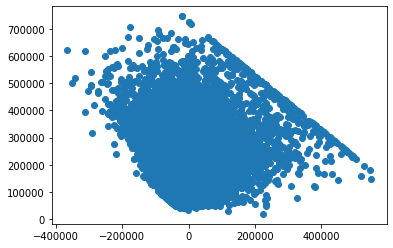

In [ ]:
x2=test_preds1.rdd.map(lambda x: x['residual']).collect()
x2_rnd=np.round(x2)
plt.scatter(x2_rnd,y_rnd)
plt.show()

<font color='darkblue'>

Plot shows a degree of randomness which suggests no key patterns in the data are being missed

</font>

<font color='brown'>
    
# D. References
    
</font>   

Allen R. (2021), Basic one way ANOVA part 1. Available from https://learn.london.ac.uk/pluginfile.php/185705/mod_resource/content/3/09.1%20ANOVA%20part%201.mp4

Drabas, Tomascz, Denny Lee (2017), Learning PySpark

Lin, T. (2018), Feature Selection Using Feature Importance Score - Creating a PySpark Estimator. Available from https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

Pulagam, S. (2020), Feature Scaling — Effectively Choose Input Variables Based on Distributions. Available from https://towardsdatascience.com/feature-scaling-effectively-choose-input-variables-based-on-distributions-3032207c921f

Social Security (2022), Average Wage Indexing (AWI) Series. Available from https://www.ssa.gov/oact/cola/awiseries.html

Social Security (2022), Estimates Under the 2022 Trustees Report. Available from https://www.ssa.gov/oact/TR/TRassum.html

SparkByExamples.com (2022), Spark Read and Write Apache Parquet. Available from https://sparkbyexamples.com/spark/spark-read-write-dataframe-parquet-example/#parquet-Partitioning

SparkByExamples.com (2022), Spark SQL UDF (User Defined Functions). Available from https://sparkbyexamples.com/spark/spark-sql-udf/

US Bureau of Labor Statistics (2021), Beyond the numbers Vol. 10/No. 1. Available from https://www.bls.gov/opub/btn/volume-10/why-computer-occupations-are-behind-strong-stem-employment-growth.htm

<font color='brown'>
    
# E. Requirements file
    
</font>   

In [ ]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
